In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df2 = pd.read_excel('C:/Users/The Josephs/Downloads/USL/Online_Retail.xlsx', encoding='ISO-8859-1')

In [4]:
df = df2.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df = df.dropna()

In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
df = df[df['Quantity']>0] # we dont want any null values
df = df[df['UnitPrice']>=0.01]

In [10]:
df['Amount'] = df['Quantity']*df['UnitPrice']

In [11]:
monetary = df.groupby('CustomerID')['Amount'].agg('sum')

In [12]:
df3 = df[['CustomerID', 'InvoiceNo']]
df3 = df3.drop_duplicates()
freq = df3.groupby('CustomerID')['InvoiceNo'].agg('count')

In [13]:
max_dt = max(df['InvoiceDate'])
max_dt

Timestamp('2011-12-09 12:50:00')

In [14]:
df['rec'] = max_dt - df['InvoiceDate']
df['rec'] = df['rec'].apply(lambda x: x.days)

In [15]:
recency = df.groupby('CustomerID')['rec'].agg('min')
recency = recency+1

In [16]:
RFM = pd.DataFrame(monetary).merge(pd.DataFrame(freq), on='CustomerID')
RFM = RFM.merge(pd.DataFrame(recency), on='CustomerID')

In [17]:
RFM.head()

,Amount,InvoiceNo,rec
CustomerID,,,
12346.0,77183.60,1,326
12347.0,4310.00,7,2
12348.0,1797.24,4,75
12349.0,1757.55,1,19
12350.0,334.40,1,310


In [18]:
RFM = RFM.rename(columns={'InvoiceNo':'Freq', 'rec':'Recency'})

In [19]:
RFM.head()

,Amount,Freq,Recency
CustomerID,,,
12346.0,77183.60,1,326
12347.0,4310.00,7,2
12348.0,1797.24,4,75
12349.0,1757.55,1,19
12350.0,334.40,1,310


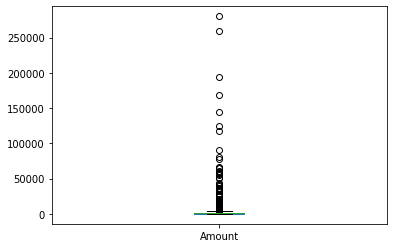

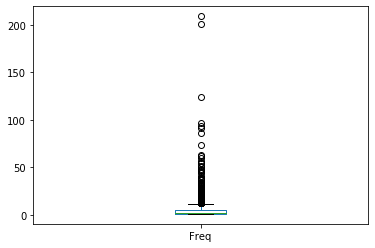

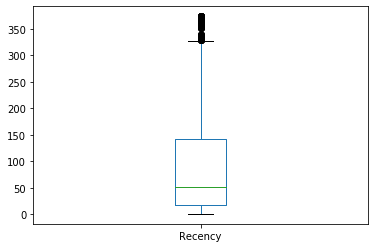

In [20]:
cols = list(RFM.columns)

for col in cols:
    RFM[col].plot(kind='box')
    plt.show()

In [21]:
RFM.shape

(4338, 3)

In [22]:
RFM.describe()

,Amount,Freq,Recency
count,4338.000000,4338.000000,4338.000000
mean,2054.266459,4.272015,92.536422
std,8989.230441,7.697998,100.014169
min,3.750000,1.000000,1.000000
25%,307.415000,1.000000,18.000000
50%,674.485000,2.000000,51.000000
75%,1661.740000,5.000000,142.000000
max,280206.020000,209.000000,374.000000


In [23]:
q1 = RFM.quantile(0.25)
q3 = RFM.quantile(0.75)

IQR = q3-q1

RFM = RFM[~(RFM>(q3+1.5*IQR))]

In [24]:
RFM.describe()

,Amount,Freq,Recency
count,3911.000000,4053.000000,4183.000000
mean,886.654536,2.958302,82.682046
std,828.537759,2.375423,87.447681
min,3.750000,1.000000,1.000000
25%,283.510000,1.000000,17.000000
50%,588.220000,2.000000,46.000000
75%,1246.210000,4.000000,123.500000
max,3692.280000,11.000000,327.000000


In [25]:
RFM = RFM.dropna()

In [26]:
RFM.shape

(3710, 3)

In [27]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

RFMs = ss.fit_transform(RFM)

In [28]:
from sklearn.cluster import KMeans
kmeans = KMeans()

ssd = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=3)
    kmeans.fit(RFMs)
    ssd1 = kmeans.inertia_
    ssd.append(ssd1)

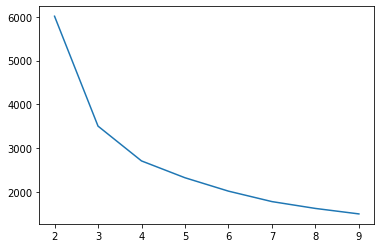

In [29]:
plt.plot(range(2, 10), ssd)
plt.show()

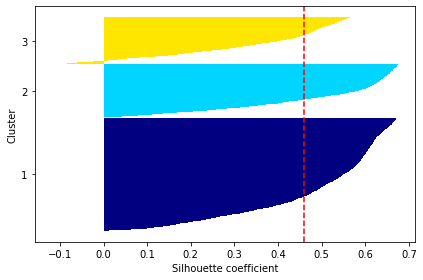

In [30]:
import plusmodules as pm
pm.svisualizer(RFMs, 3)

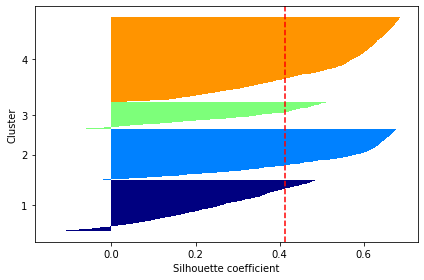

In [31]:
pm.svisualizer(RFMs, 4)

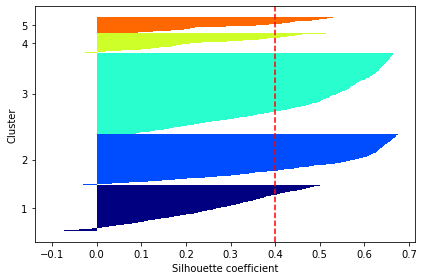

In [32]:
pm.svisualizer(RFMs, 5)

In [33]:
kmeans = KMeans(n_clusters=3, random_state=3)
kmeans.fit(RFMs)

KMeans(n_clusters=3, random_state=3)

In [34]:
RFM['cluster'] = kmeans.labels_

In [35]:
RFM['cluster'].value_counts()

2    1969
1     920
0     821
Name: cluster, dtype: int64

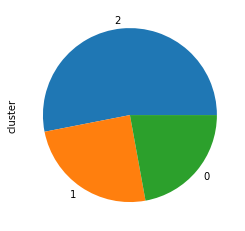

In [36]:
RFM['cluster'].value_counts().plot(kind='pie')
plt.show()

In [37]:
RFM.groupby('cluster').agg('mean')

,Amount,Freq,Recency
cluster,,,
0,2108.706821,6.049939,36.147381
1,414.094598,1.498913,226.802174
2,599.217044,2.120874,48.814119


In [38]:
rec = RFM.groupby('cluster')['Recency'].agg('mean')
freq = RFM.groupby('cluster')['Freq'].agg('mean')
monetary = RFM.groupby('cluster')['Amount'].agg('mean')

In [48]:
print('''mean of customers recency in each clusters:''')
rec

mean of customers recency in each clusters:


cluster
0     36.147381
1    226.802174
2     48.814119
Name: Recency, dtype: float64

In [46]:
print('''mean of customers monetary in each clusters:''')
monetary

cluster
0    2108.706821
1     414.094598
2     599.217044
Name: Amount, dtype: float64

In [49]:
print('''mean of customers frequency in each clusters:''')
freq

mean of customers frequency in each clusters:


cluster
0    6.049939
1    1.498913
2    2.120874
Name: Freq, dtype: float64

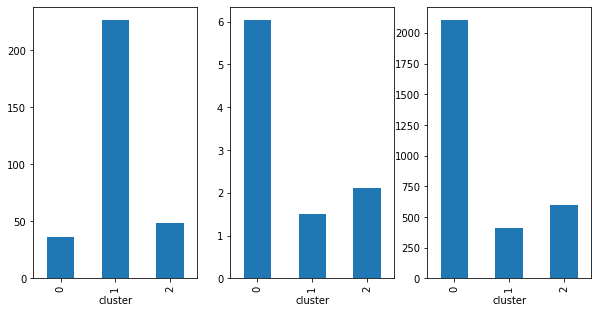

In [39]:
fig, axis = plt.subplots(1,3, figsize=(10, 5))
rec.plot.bar(ax=axis[0])
freq.plot.bar(ax=axis[1])
monetary.plot.bar(ax=axis[2])
plt.show()

### Inference :
*from plot 1 we see deduce that people in cluster 1 have the highest recency as in they have visted the shop very recently.
from plot 2 we can deduce that people in cluster 0 have come frequently to the shop.
from plot 3 we can deduce that people in cluter 0 have purchased a lot over 1 and 2 and conributed much to the economy of the shop.

### conclusion :
 so the conclusion is people from cluster 0 have been valuable customers but in recent times they are not visiting the shop.
 so new customers are coming to the shop and there is drop in old customers. we need to find out the reason behind this drop
 and bring about strategies to retain the old customers who add value to the shop.